In [1]:
import os
import numpy as np
import scipy.stats as stats
from statsmodels.robust.scale import mad
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from matplotlib import pyplot

import flowio

%matplotlib inline

In [2]:
time_channel = "Time"
data_channel = "SSC-A"
data_dir = "/home/swhite/Projects/flowClean_testing/data"
diff_roll = 0.01
final_roll = 0.02
k = 2.0
k2 = 3.0

figure_out_dir = "flow_rate_qc_square"
fig_size = (16, 4)

In [3]:
def find_channel_index(channel_dict, pnn_text):
    for k, v in channel_dict.iteritems():
        if v['PnN'] == pnn_text:
            index = int(k) - 1
    
    return index

In [4]:
def calculate_flow_rate(events, time_index, roll):
    time_diff = np.diff(events[:, time_index])
    time_diff = np.insert(time_diff, 0, 0)
    
    time_diff_mean = pd.rolling_mean(time_diff, roll, min_periods=1)
    min_diff = time_diff_mean[time_diff_mean > 0].min()
    time_diff_mean[time_diff_mean == 0] = min_diff
    
    flow_rate = 1 / time_diff_mean
    
    return flow_rate

In [5]:
def plot_channel(file_name, x, y, x_label, y_label):
    pre_scale = 0.003
    
    my_cmap = pyplot.cm.get_cmap('jet')
    my_cmap.set_under('w', alpha=0)
    
    bins = int(np.sqrt(x.shape[0]))
    
    fig = pyplot.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title(file_name, fontsize=16)
    
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    ax.hist2d(
        x,
        np.arcsinh(y * pre_scale),
        bins=[bins, bins],
        cmap=my_cmap,
        vmin=0.9
    )
    
    fig.tight_layout()
    
    pyplot.show()

In [6]:
def plot_flow_rate(
        file_name, 
        flow_rate, 
        event_idx, 
        hline=None, 
        trendline=None, 
        x_lim=None, 
        y_lim=None,
        save_figure=False
    ):
    
    fig = pyplot.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title(file_name, fontsize=16)
    
    ax.set_xlabel("Event", fontsize=14)
    ax.set_ylabel("Flow rate (events/ms)", fontsize=14)
    
    if x_lim is None:
        ax.set_xlim([0, max(event_idx)])
    else:
        ax.set_xlim([x_lim[0], x_lim[1]])
    
    if y_lim is not None:
        ax.set_ylim([y_lim[0], y_lim[1]])
    
    ax.plot(
        event_idx,
        flow_rate,
        c='darkslateblue'
    )
    
    if hline is not None:
        ax.axhline(hline, linestyle='-', linewidth=1, c='coral')
    
    if trendline is not None:
        ax.plot(event_idx, trendline, c='cornflowerblue')
    
    fig.tight_layout()
        
    if save_figure:
        fig_name = "".join([file_name, '_a_', 'flow_rate.png'])
        fig_path = "/".join([figure_out_dir, fig_name])
        pyplot.savefig(fig_path)

    pyplot.show()

In [7]:
def plot_deviation(
        file_name, 
        flow_rate, 
        event_indices, 
        diff, 
        stable_diff, 
        smooth_stable_diff, 
        threshold,
        save_figure=False
    ):
    fig = pyplot.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title(file_name, fontsize=16)

    ax.set_xlim([0, len(flow_rate)])
    #pyplot.ylim([0, 5])

    ax.set_xlabel("Event", fontsize=14)
    ax.set_ylabel("Deviation (log)", fontsize=14)

    ax.plot(
        event_indices,
        np.log10(1 + diff),
        c='coral',
        alpha=0.6,
        linewidth=1
    )

    ax.plot(
        event_indices,
        np.log10(1 + stable_diff),
        c='cornflowerblue',
        alpha=0.6,
        linewidth=1
    )

    ax.plot(
        event_indices,
        np.log10(1 + smooth_stable_diff),
        c='darkslateblue',
        alpha=1.0,
        linewidth=1
    )

    ax.axhline(np.log10(1 + threshold), linestyle='dashed', linewidth=2, c='crimson')
    
    fig.tight_layout()
        
    if save_figure:
        fig_name = "".join([file_name, '_b_', 'deviation.png'])
        fig_path = "/".join([figure_out_dir, fig_name])
        pyplot.savefig(fig_path)

    pyplot.show()

In [8]:
def plot_channel_good_vs_bad(
        file_name,
        channel_data,
        time_data,
        channel_name,
        good_event_map,
        bi_ex=True,
        save_figure=False,
        drop_negative=False
    ):

    pre_scale = 0.003
    
    good_cmap = pyplot.cm.get_cmap('jet')
    good_cmap.set_under('w', alpha=0)
    
    bad_cmap = pyplot.cm.get_cmap('jet')
    bad_cmap.set_under('w', alpha=0)
        
    x_good = time_data[good_event_map]
    x_bad = time_data[~good_event_map]
    
    if bi_ex:
        y_good = np.arcsinh(channel_data[good_event_map] * pre_scale)
        y_bad = np.arcsinh(channel_data[~good_event_map] * pre_scale)
    else:
        y_good = channel_data[good_event_map]
        y_bad = channel_data[~good_event_map]
    
#     if drop_negative:
#         pos_good_indices = y_good > 0
#         y_good = y_good[pos_good_indices]
#         x_good = x_good[pos_good_indices]
        
#         pos_bad_indices = y_bad > 0
#         y_bad = y_bad[pos_bad_indices]
#         x_bad = x_bad[pos_bad_indices]
    
    bins_good = int(np.sqrt(good_event_map.shape[0]))
    bins_bad = bins_good
    
    if bins_good >= y_good.shape[0]:
        print("Good values less than bins: %s" % file_name)
        return
    if bins_bad >= y_bad.shape[0]:
        print("Bad values less than bins: %s" % file_name)
        return
    
    fig = pyplot.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title(file_name, fontsize=16)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(channel_name, fontsize=14)
    
    ax.hist2d(
        x_good,
        y_good,
        bins=[bins_good, bins_good],
        cmap=good_cmap,
        vmin=0.9
    )
    
    ax.hist2d(
        x_bad,
        y_bad,
        bins=[bins_bad, bins_bad],
        cmap=bad_cmap,
        vmin=0.9,
        alpha=0.3
    )
    
    if drop_negative:
        ax.set_ylim(ymin=0)
    
    fig.tight_layout()
        
    if save_figure:
        fig_name = "".join([file_name, '_c_', 'filtered_events.png'])
        fig_path = "/".join([figure_out_dir, fig_name])
        pyplot.savefig(fig_path)

    pyplot.show()

In [9]:
def clean(fcs_file, save_figures=False):
    fd = flowio.FlowData("/".join([data_dir, fcs_file]))
    events = np.reshape(fd.events, (-1, fd.channel_count))
    
    time_index = find_channel_index(fd.channels, time_channel)
    
    diff_roll_count = int(diff_roll * events.shape[0])
    flow_rate = calculate_flow_rate(events, time_index, diff_roll_count)
    
    median = np.median(flow_rate)
    median_diff = np.abs(flow_rate - median)
    
    threshold = k * mad(median_diff)
    initial_good_events = median_diff < threshold
    
    event_indices = np.arange(0, len(flow_rate))
    good_event_indices = event_indices[initial_good_events]
    
    line_regress = stats.linregress(good_event_indices, flow_rate[initial_good_events])
    
    linear_fit = (line_regress.slope * event_indices) + line_regress.intercept
    stable_diff = np.abs(flow_rate - linear_fit)
    
    final_threshold = k2 * mad(stable_diff)
    
    final_w = int(final_roll * stable_diff.shape[0])
    smoothed_diff = pd.rolling_mean(stable_diff, window=final_w, min_periods=1, center=True)
    final_good_events = smoothed_diff < final_threshold
    
    plot_flow_rate(
        fd.name, 
        flow_rate, 
        event_indices, 
        hline=median, 
        trendline=linear_fit,
        save_figure=save_figures
    )
    
    plot_deviation(
        fd.name, 
        flow_rate, 
        event_indices, 
        median_diff, 
        stable_diff, 
        smoothed_diff, 
        final_threshold,
        save_figure=save_figures
    )
    
    data_channel_index = find_channel_index(fd.channels, data_channel)
    plot_channel_good_vs_bad(
        fd.name, 
        events[:, data_channel_index], 
        events[:, time_index], 
        data_channel, 
        final_good_events,
        save_figure=save_figures,
        drop_negative=True
    )
    
    return final_good_events

In [10]:
if not os.path.isdir(figure_out_dir):
    os.mkdir(figure_out_dir)

save_fig = False

In [11]:
fcs_files = os.listdir(data_dir)
fcs_files = sorted(fcs_files)

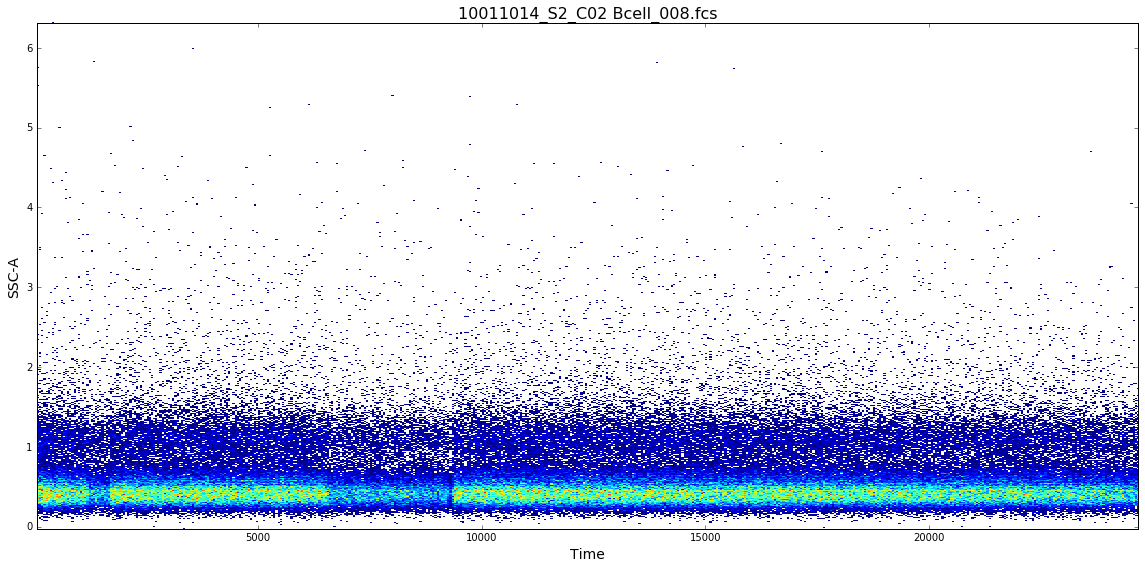

In [12]:
fd = flowio.FlowData("/".join([data_dir, fcs_files[7]]))
events = np.reshape(fd.events, (-1, fd.channel_count))
plot_channel(fd.name, events[:, 14], events[:, 3], 'Time', 'SSC-A')

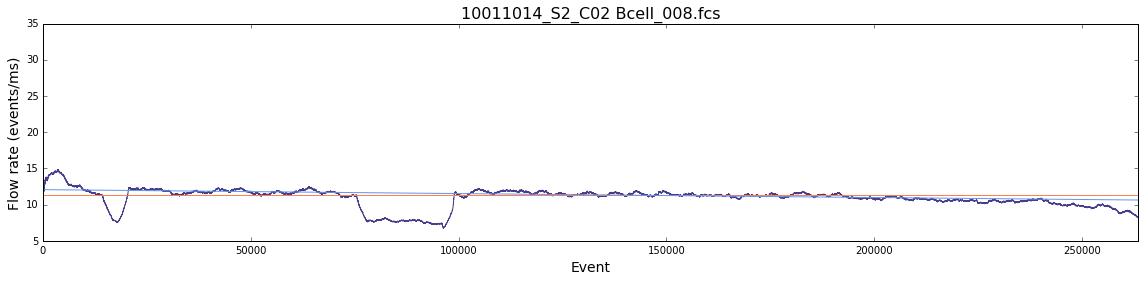

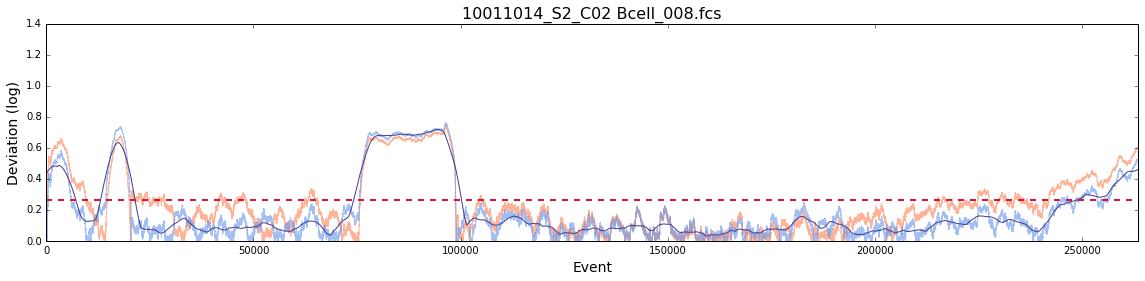

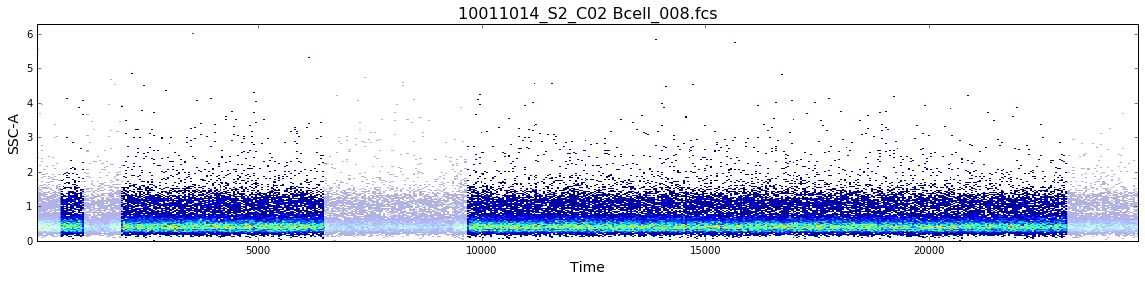

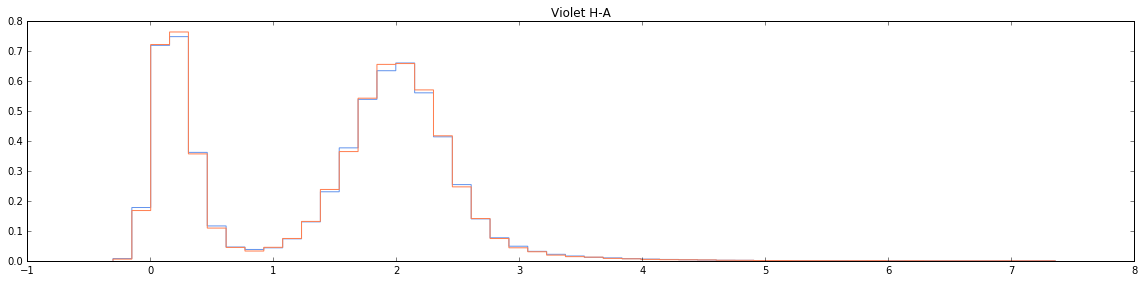

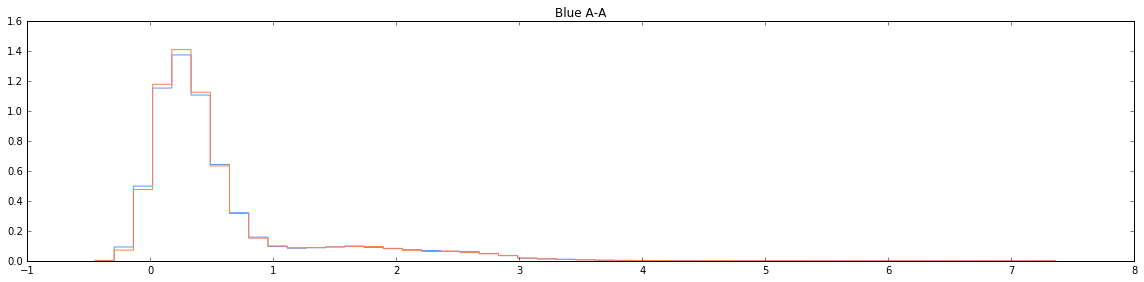

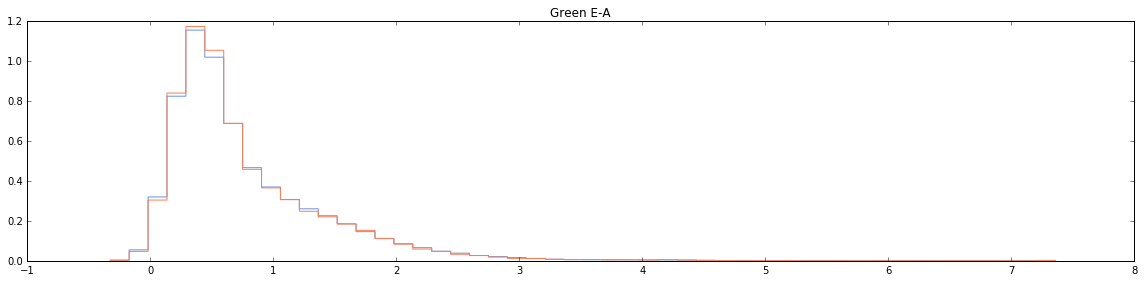

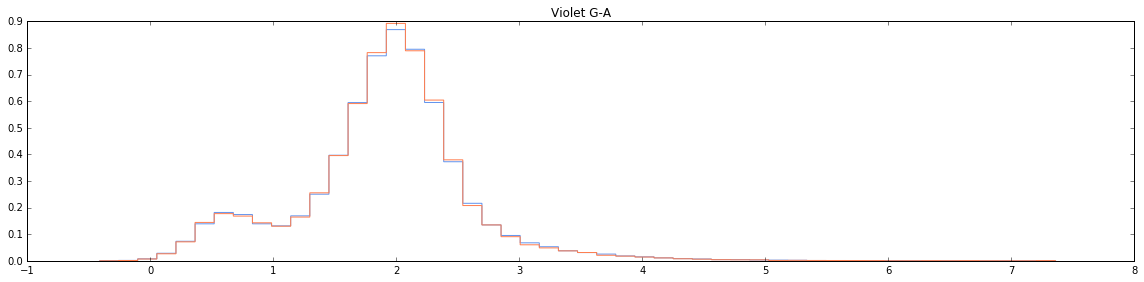

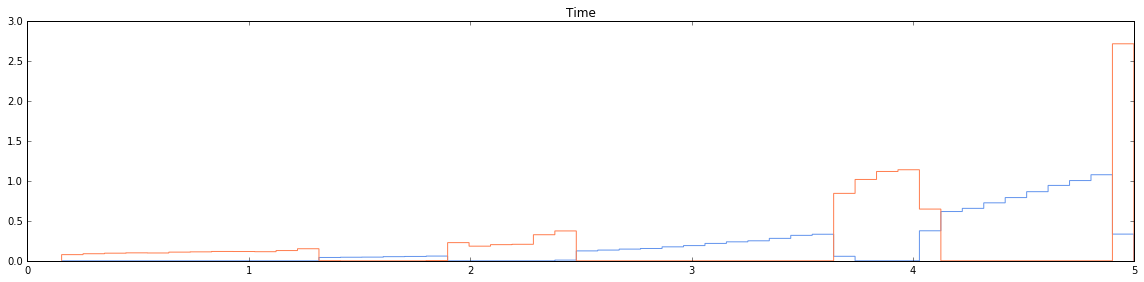

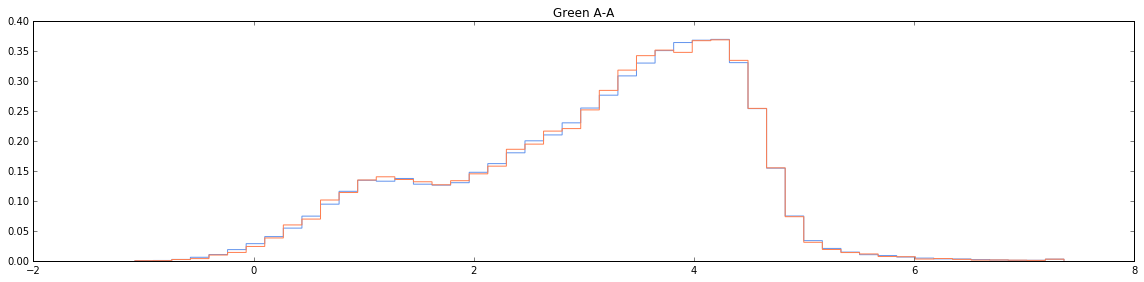

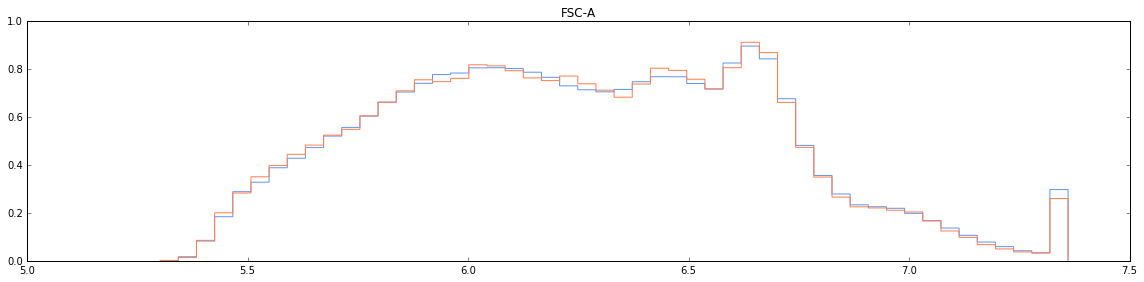

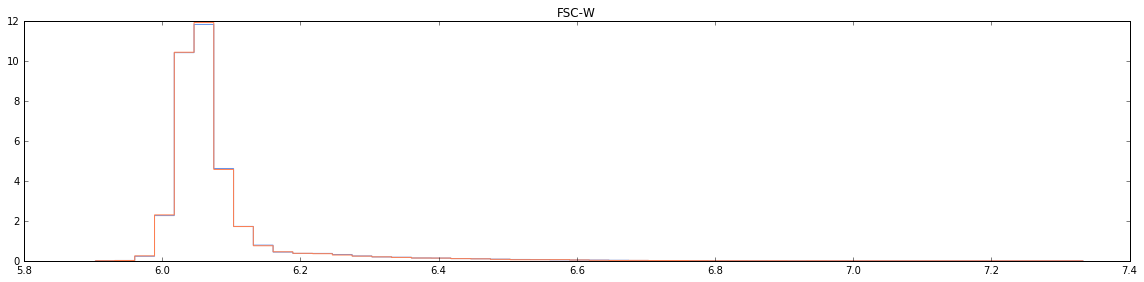

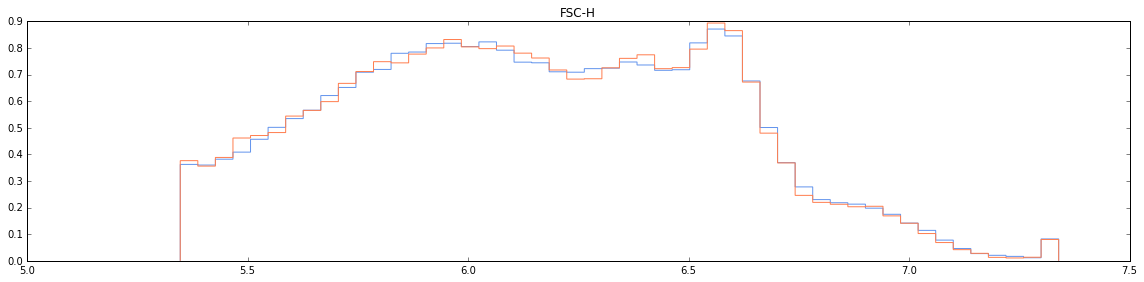

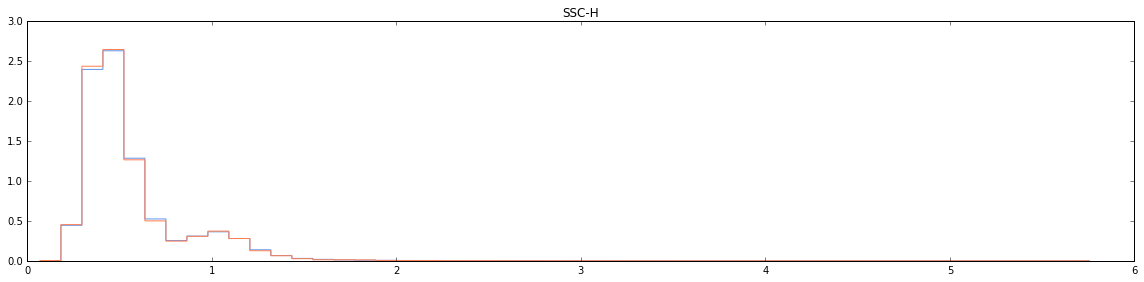

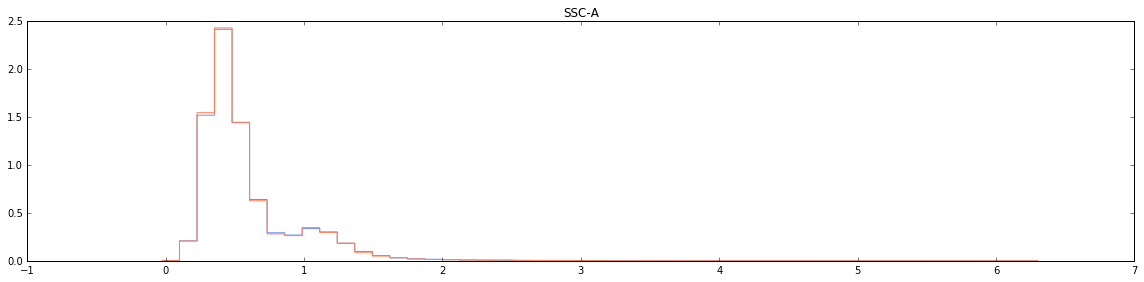

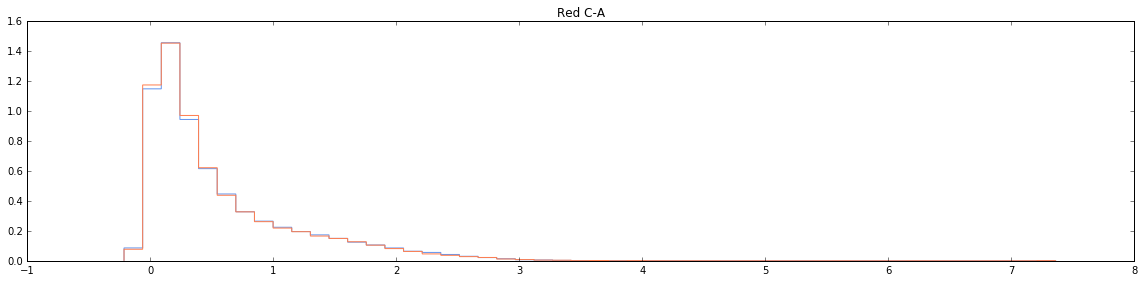

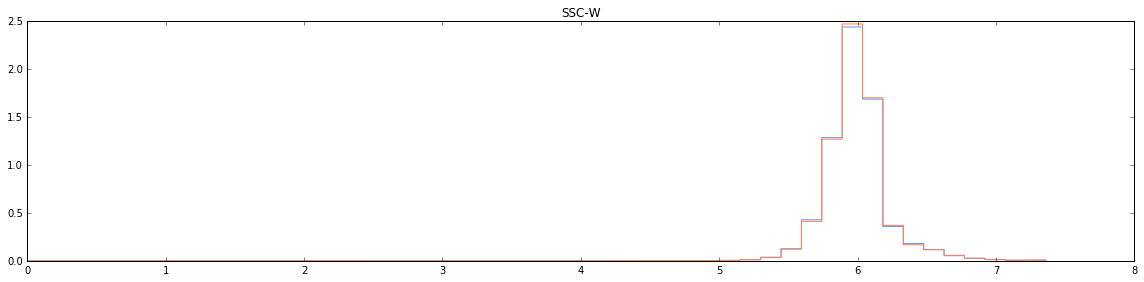

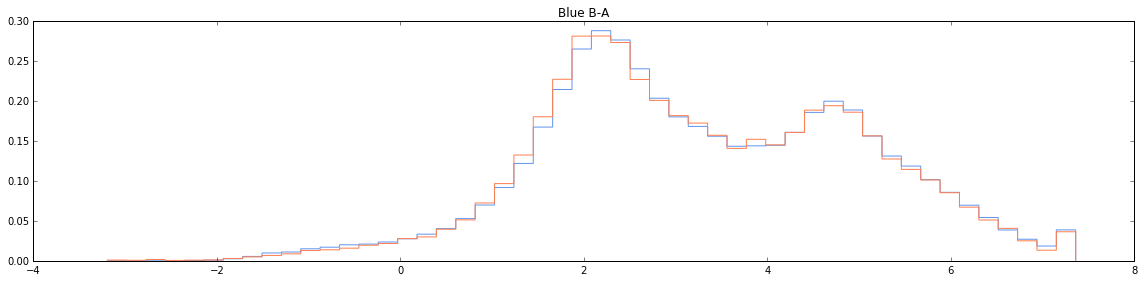

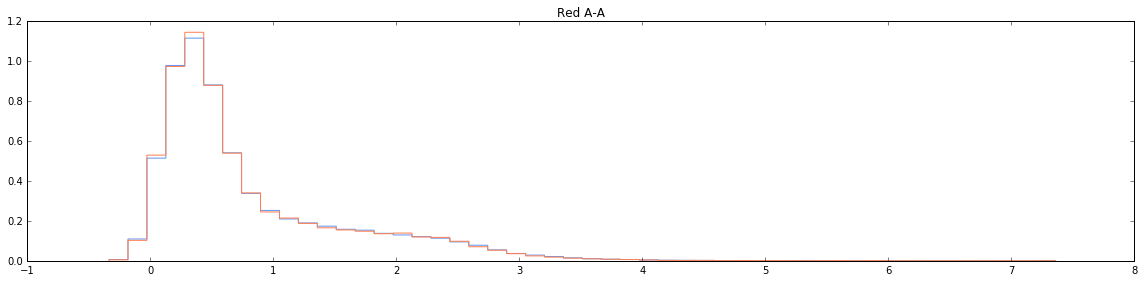

In [13]:
f = fcs_files[7]

fd = flowio.FlowData("/".join([data_dir, f]))
events = np.reshape(fd.events, (-1, fd.channel_count))

good = clean(f, save_figures=False)

n_bins = 50

for channel in fd.channels:
    channel_name = fd.channels[channel]['PnN']
    
    fig = pyplot.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 1, 1)
    
    good_events = np.arcsinh(events[good, int(channel) - 1] * 0.003)
    bad_events = np.arcsinh(events[~good, int(channel) - 1] * 0.003)
    
    #ax.hist([good_events, bad_events], n_bins, normed=1, histtype='bar', stacked=True, color=['cornflowerblue', 'coral'])
    ax.hist([bad_events, good_events], n_bins, normed=1, histtype='step', color=['coral', 'cornflowerblue'])
    
    ax.set_title(channel_name)
    
    pyplot.tight_layout()
    pyplot.show()

In [ ]:
x = np.random.randn(1000, 3)
x.shape

In [ ]:
save_fig=True

In [ ]:
for fcs_file in fcs_files:
    clean(fcs_file, save_figures=save_fig)